In [141]:
#import libraries
import numpy as np
import math
import random
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy import stats, special
import sys
from itertools import cycle

#allows Jupyter to render graphs inline
%matplotlib inline

In [142]:
'''
Node class represents a single point in the TSP graph
name: node number
x: x coordinate
y: y coordinate
'''
class Node:
    #Constructor for the class
    def __init__(self, name, x, y):
        self.name = name
        self.x = x
        self.y = y
     
    '''
    Computes the euclidean distance between this node and a given node
    Input: Node object
    Output: float distance
    '''
    def distance(self, node):
        return math.sqrt((self.x-node.x)**2 + (self.y-node.y)**2)

'''
Individual class represents a path and is a member of the population
path: list of nodes
distance: overall path length
fitness: 1/distance
'''    
class Individual:
    #Constructor
    def __init__(self, path):
        self.path = path
        self.distance = 0.0
        self.fitness = 0.0
    
    '''
    Computes the path length of the individual
    Input: None
    Output: float path_length
    '''
    def path_length(self):
        pl = 0
        for i in range(0, len(self.path)):
            node1 = self.path[i]
            node2 = None
            if i+1 < len(self.path):
                node2 = self.path[i+1]
            else:
                node2 = self.path[0]
            pl = pl + node1.distance(node2)
            self.distance = pl
            self.fitness = 1/float(pl)
        return pl
    
    '''
    Returns the object's path as a list of strings
    Input: None
    Output: list path
    '''
    def get_path(self):
        path_list = []
        for i in self.path:
            path_list.append(i.name)
        return path_list

'''
Creates the first population by random selection of paths
Input: int population_size, list collection_of_nodes
Output: list collection_of_individuals
'''
def initialize_pop(pop_size, nodes):
    population = []
    for i in range(0, pop_size):
        route = random.sample(nodes, len(nodes))
        individual = Individual(route)
        population.append(individual)
    return population

'''
Reads in a .tsp file and creates the collection of Nodes
Input: string file_name
Output: list collection_of_nodes
'''
def read_tsp(file_name):
    nodes = []
    with open(file_name, "r") as file:
        data = file.readlines()
        
    for i in data:
        split_i = i.split(" ")
        if len(split_i) == 3:
            nodes.append(Node(int(split_i[0]), float(split_i[1]), float(split_i[2])))
    return nodes

'''
Computes the fitness values for a population within each individual
Input: list population_of_individuals
Output: None
'''
def find_fitnesses(population):
    for i in range(0, len(population)):
        population[i].path_length()

'''
Performs an elite ranking of the popluation.  The population is sorted based on fitness and 
the top gen_size is returned as a mating pool
Input: list population_of_individuals, int gen_size
Output: list sorted_and_filtered_population
'''
def rank_population_elite(population, gen_size):
    sorted_pop = sorted(population, key=lambda x: x.fitness, reverse=True)
    return sorted_pop[:gen_size]
    
    
'''
Ranks the population and selects individuals for futher ranking based on a probability
scaled based on each individual's fitness score
Input: list population_of_individuals, int gen_size
Output: list ranked_population_of_individuals
'''    
def rank_population_proportional(population, gen_size):
    selected = []
    pop_list = []
    for i in range(0, len(population)):
        pop_list.append((i, population[i].fitness))
        
    df = pd.DataFrame(pop_list, columns=["Individual", "Fitness"])
    df['breeding_chance'] = df.Fitness/df.Fitness.sum()
    for i in range(0, gen_size):
        selection = random.uniform(0,1)
        j = 0
        while True:
            row = df.iloc[j]
            selection -= row['breeding_chance']
            if selection < 0:
                break
            j+=1
        selected_row = df.iloc[j]
        selected.append(int(selected_row['Individual']))
        selected_prob = selected_row['breeding_chance']
        df = df.drop(j)
        df = df.reset_index(drop=True)
        if len(df) > 0:
            df["breeding_chance"] += selected_prob/len(df)
        
    return [population[i] for i in selected]

'''
Helper function that breeds two parents using one-point crossover
Input: Individual parent1, Individual parent2, list collection_of_nodes
Output: Individual child
'''
def breed(parent1, parent2, nodes):
    
    p1_path = parent1.get_path()
    p2_path = parent2.get_path()
    
    gene1 = int(random.random()*len(p1_path))
    gene2 = int(random.random()*len(p1_path))
    
    start_idx = min(gene1, gene2)
    end_idx = max(gene1, gene2)
    
    segment_p1 = p1_path[start_idx:end_idx]
    segment_p2 = [i for i in p2_path if i not in segment_p1]
    
    new_path = segment_p1 + segment_p2
    child_path = []
    
    for i in new_path:
        for j in nodes:
            if j.name == i:
                child_path.append(Node(i, j.x, j.y))
    
    
    child = Individual(child_path)
    
    return Individual(child_path)

'''
Uses the breed() function to breed random pairs of individuals within a population
Input: list pool_of_parents, list collection_of_nodes
Output: list next_generation
'''
def breed_pop(pool, size, nodes):
    children = []
    
    for i in pool:
        children.append(i)
    
    while len(children) != size:
        parents = random.sample(pool, 2)
        child = breed(parents[0], parents[1], nodes)
        children.append(child)
        
    return children

'''
Performs an in-place swap mutation in an individual
Input: Individual i
Output: None
'''
def mutate(individual):
    num_nodes = len(individual.path)
    idx1 = int(random.random()*num_nodes)
    idx2 = int(random.random()*num_nodes) 
    individual.path[idx1], individual.path[idx2] = individual.path[idx2], individual.path[idx1]

'''
Rolls for whether an individual should be mutate based on the mut_rate.  If 
the random roll is smaller, then individual is mutated.  This function is performed across
the population
Input: list population_of_individuals, float mut_rate
Output: None
'''
def mutate_population(population, mut_rate):
    for i in population:
        chance = random.random()
        if chance <= mut_rate:
            mutate(i)

'''
Collection of previous methods to make a new generation.  It takes a population,
selects the mating pool, breeds them, and performs mutations across that generation
Input: list current_generation, float mut_rate, int desired_population_size,
    int ranked_selection_size, object method_of_selection, list collection_of_nodes
Output: list new_generation_of_individuals
'''
def make_generation(curr_gen, mut_rate, pop_size, select_size, selection_method, nodes):
    pop_to_breed = selection_method(curr_gen, select_size)
    new_generation = breed_pop(pop_to_breed, pop_size, nodes)
    mutate_population(new_generation, mut_rate)
    return new_generation

'''
Runs make_generation() for num_generations and records the results
Input: list collection_of_nodes, int, number_of_generations, float mut_rate, int desired_population_size,
    int ranked_selection_size, object method_of_selection
Output: float best_distance, list best_path
'''
def run_ga_tsp(nodes, num_generations, mut_rate, pop_size, select_size, selection_method):
    start_time = time.time()
    avg_gen_fit_list = []
    best_gen_fit_list = []
    
    pop = initialize_pop(pop_size, nodes)
    find_fitnesses(pop)
    
    best_fit = 0
    best_path = 0
    best_dist = math.inf
    
    for i in range(0, num_generations):
        pop = make_generation(pop, mut_rate, pop_size, select_size, selection_method, nodes)
        find_fitnesses(pop)
        
        best_gen_fit = 0
        sum_gen_fit = 0
        for j in pop:
            if j.fitness > best_gen_fit:
                best_gen_fit = j.fitness
            if best_gen_fit > best_fit:
                best_fit = best_gen_fit
                best_path = j.get_path()
            if j.distance < best_dist:
                best_dist = j.distance
            sum_gen_fit += j.fitness
        avg_gen_fit = sum_gen_fit/len(pop)
        best_gen_fit_list.append(best_gen_fit)
        avg_gen_fit_list.append(avg_gen_fit)
        
    print("Execution time: " + str(time.time()-start_time))
    
    fig, ax = plt.subplots(2, figsize=(12,12))
    ax[0].plot(range(1, len(avg_gen_fit_list)+1), avg_gen_fit_list)
    ax[0].set_title("Average Fitness by Generation")
    ax[1].plot(range(1, len(best_gen_fit_list)+1), best_gen_fit_list)
    ax[1].set_title("Best Fitness by Generation")
    
    fig.text(0.5, 0.04, "Generation", ha="center")
    fig.text(0.04, 0.5, "Fitness Scores", va="center", rotation=90)
    
    print("Best Overall Fitness: " + str(best_fit))
    print("Best Path: " + str(best_path))
    print("Best Overall Distance: " + str(best_dist))
    
    return (best_dist, best_path)

def count_connections(paths, n_cities):
    adj_matrix = np.zeros((n_cities, n_cities), dtype=float)
    for i in paths:
        for first, second in zip(i, i[1:]):
            adj_matrix[first-1][second-1] += 1
            adj_matrix[second-1][first-1] += 1
            
    for i in range(0, n_cities):
        for j in range(0, n_cities):
            adj_matrix[i][j] = adj_matrix[i][j]/n_cities
            
    return adj_matrix

def cost_transform(adj_matrix, a, b):
    size = len(adj_matrix)
    transform = np.copy(adj_matrix)
    for i in range(0, size):
        for j in range(0, size):
             transform[i][j] = 1-special.betaincinv(a, b,  transform[i][j])
            
    return  transform

# Test 1 - Control


Generation 0

Execution time: 4.683338165283203
Best Overall Fitness: 0.00212016120603029
Best Path: [1, 5, 4, 19, 13, 10, 6, 8, 12, 21, 17, 11, 16, 3, 15, 20, 22, 14, 9, 2, 18, 7]
Best Overall Distance: 471.66224773651174

Generation 1

Execution time: 3.858985424041748
Best Overall Fitness: 0.0023009882769506823
Best Path: [1, 5, 18, 22, 20, 2, 14, 9, 4, 13, 19, 10, 6, 12, 8, 17, 21, 11, 16, 3, 15, 7]
Best Overall Distance: 434.5958690955266

Generation 2

Execution time: 3.9303925037384033
Best Overall Fitness: 0.002171037023458287
Best Path: [7, 1, 5, 6, 13, 4, 19, 10, 12, 8, 17, 21, 11, 16, 3, 15, 20, 22, 14, 9, 2, 18]
Best Overall Distance: 460.6093720166414

Generation 3

Execution time: 4.201572418212891
Best Overall Fitness: 0.0021617443762617676
Best Path: [16, 11, 17, 21, 8, 12, 6, 10, 13, 19, 4, 5, 1, 7, 14, 9, 18, 2, 20, 22, 15, 3]
Best Overall Distance: 462.58938428662253

Generation 4

Execution time: 4.554701089859009
Best Overall Fitness: 0.0021307978998582264
Best Pa

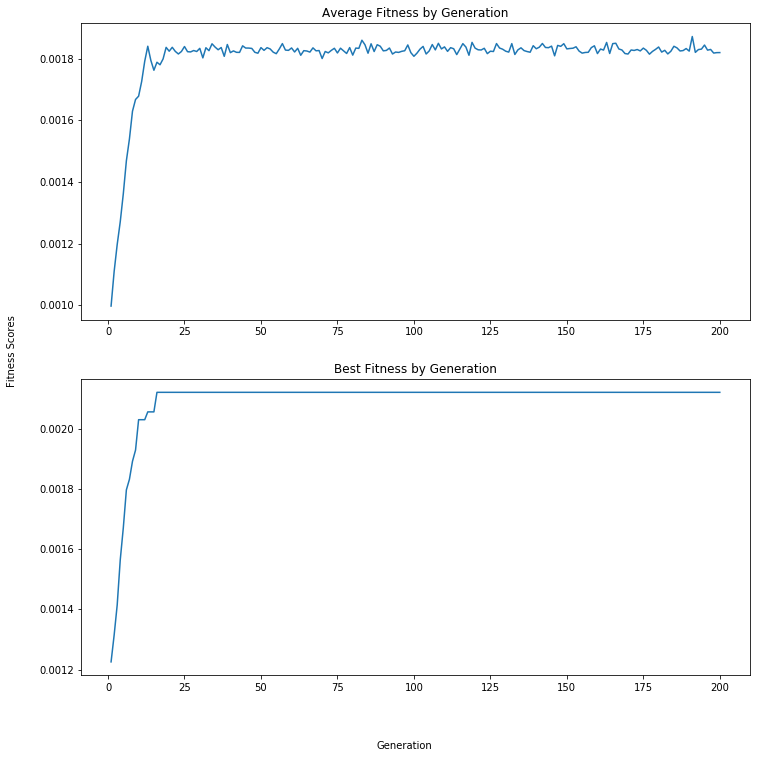

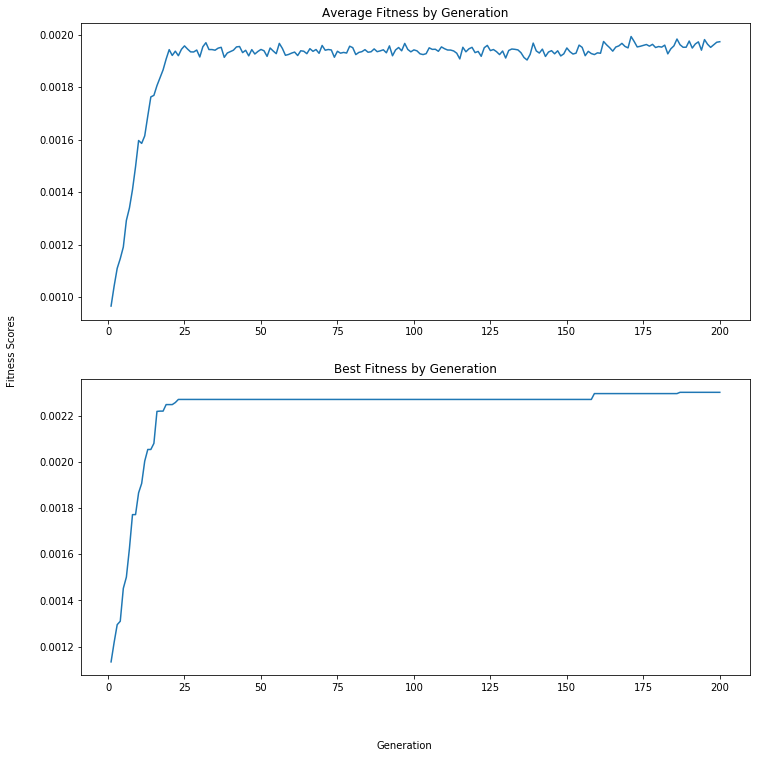

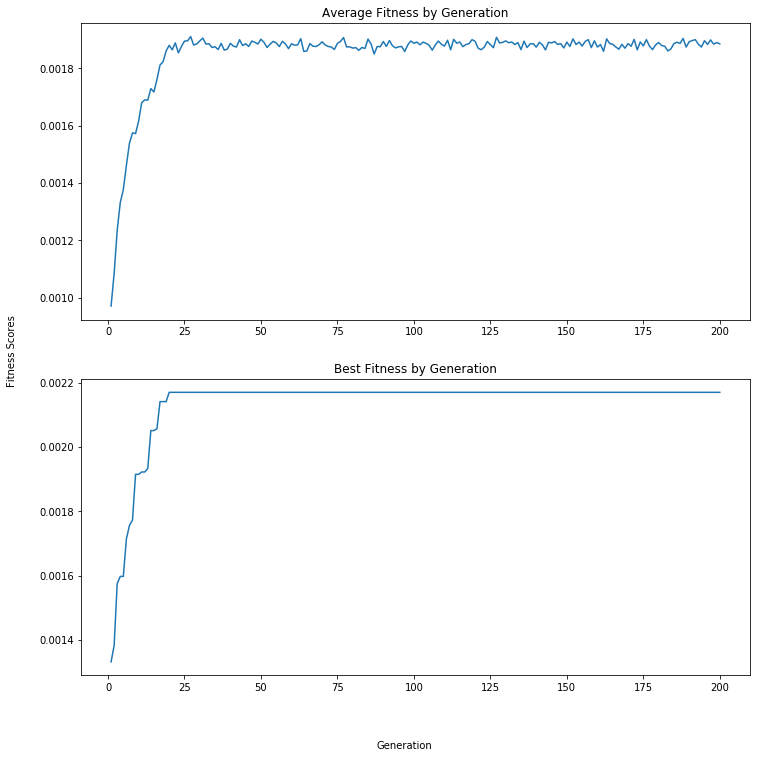

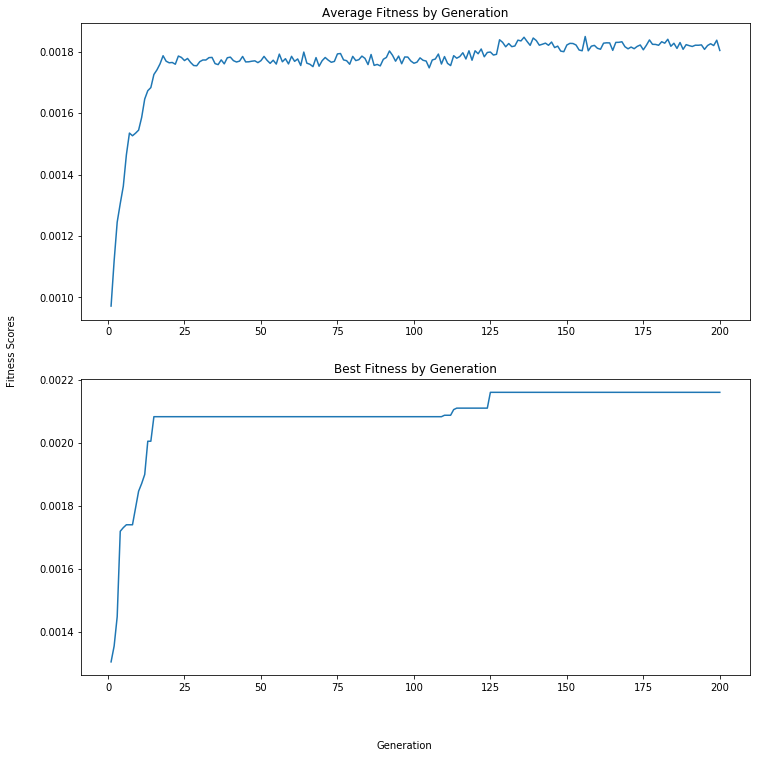

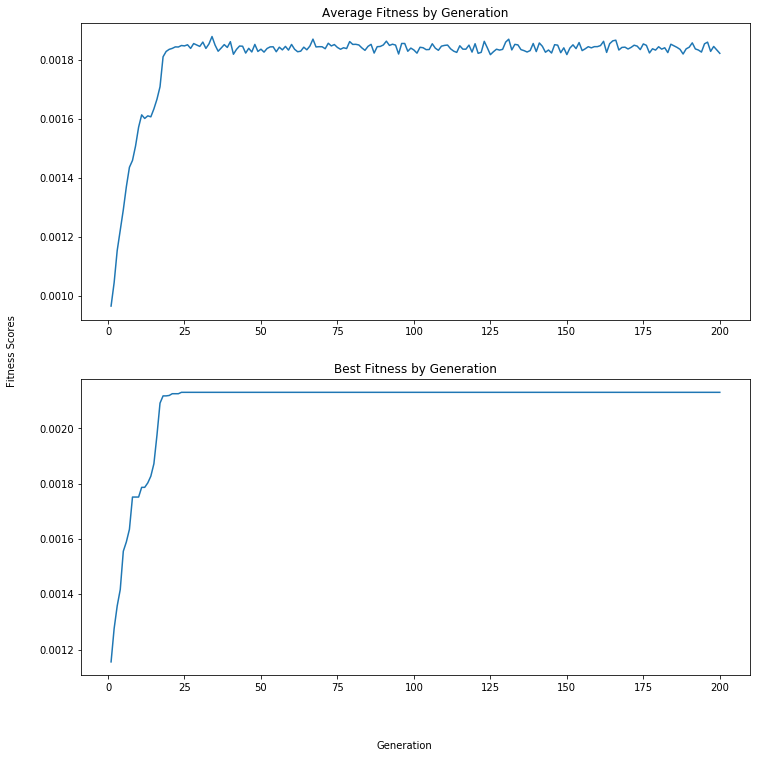

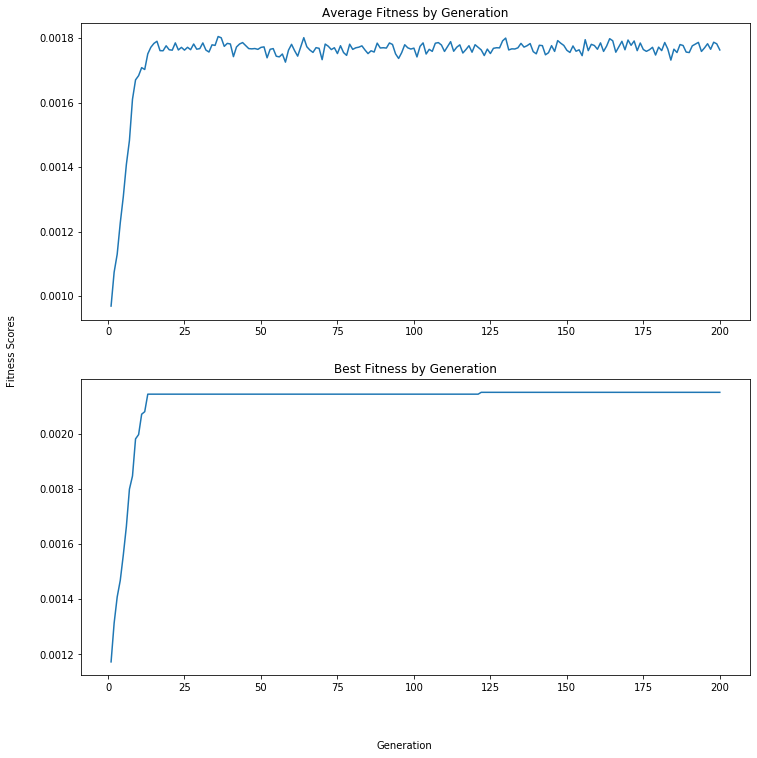

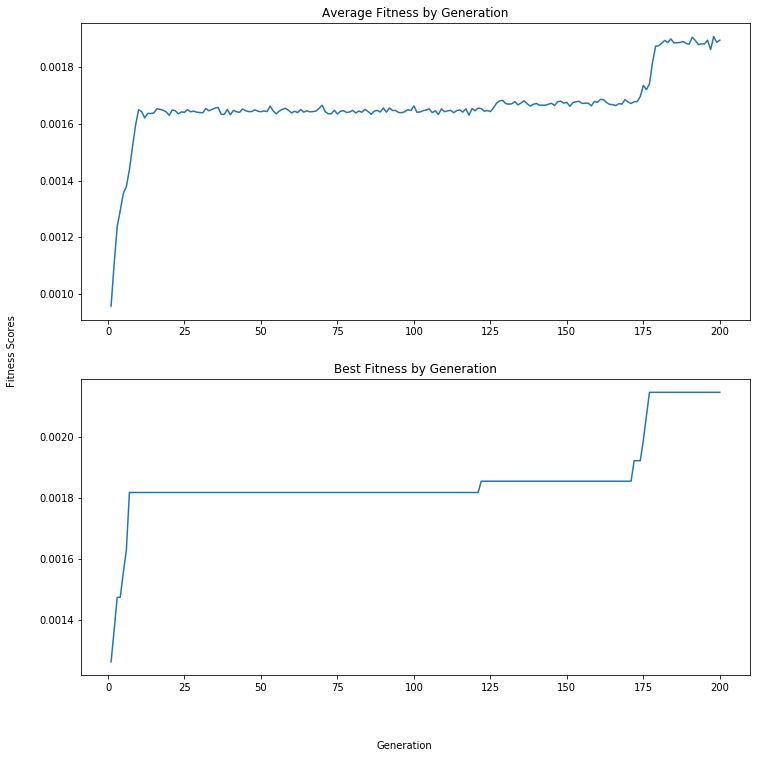

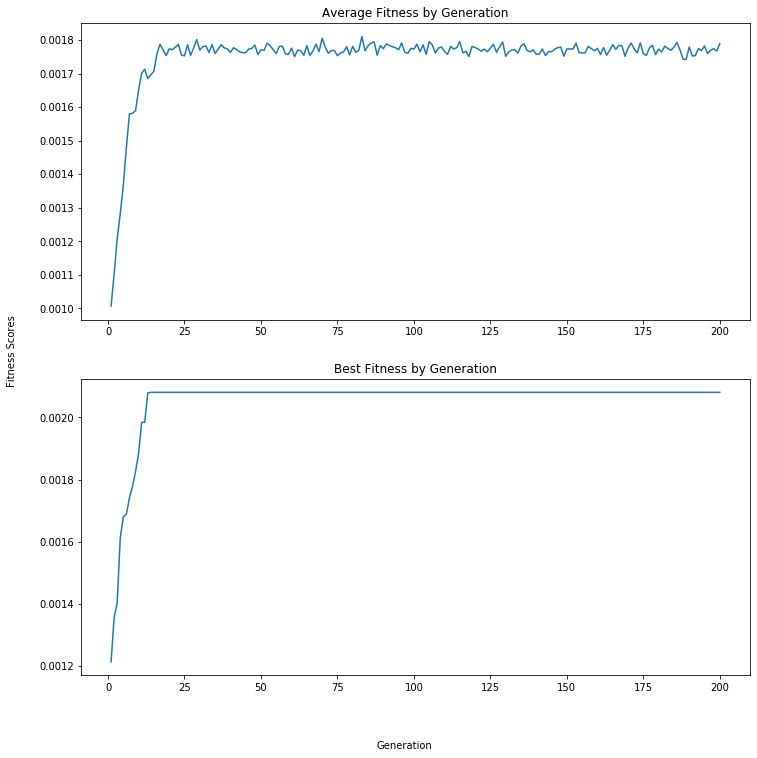

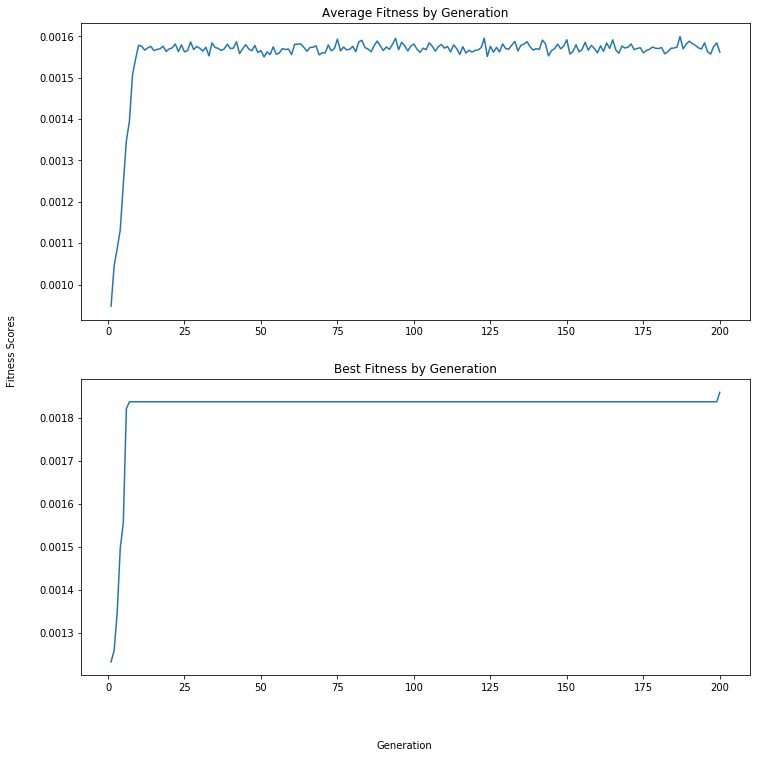

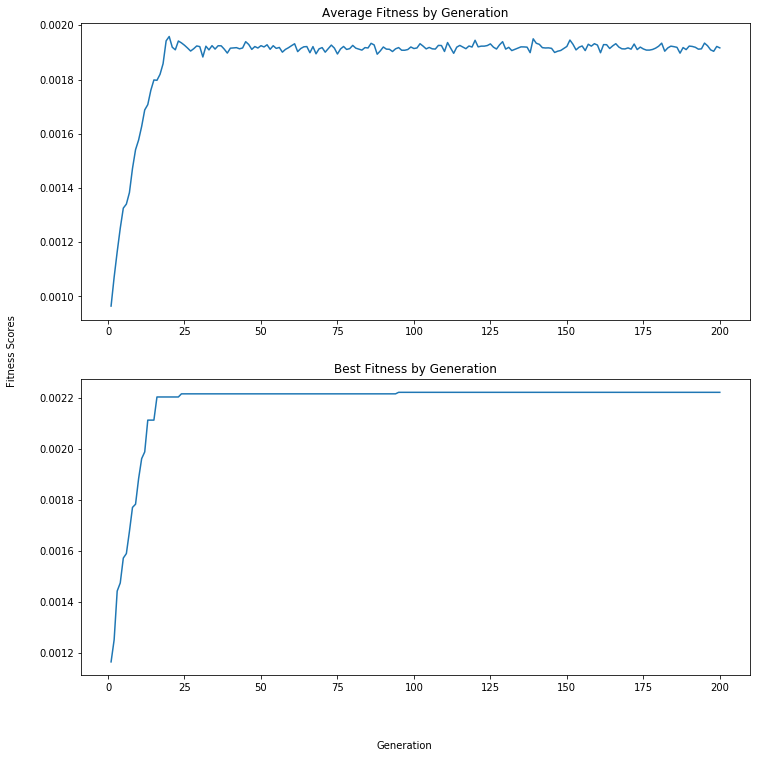

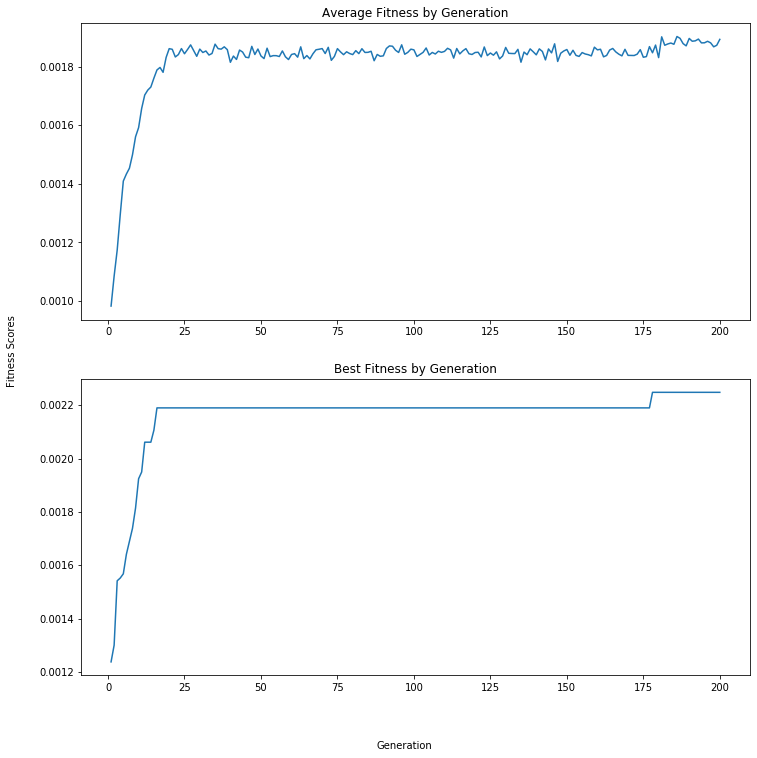

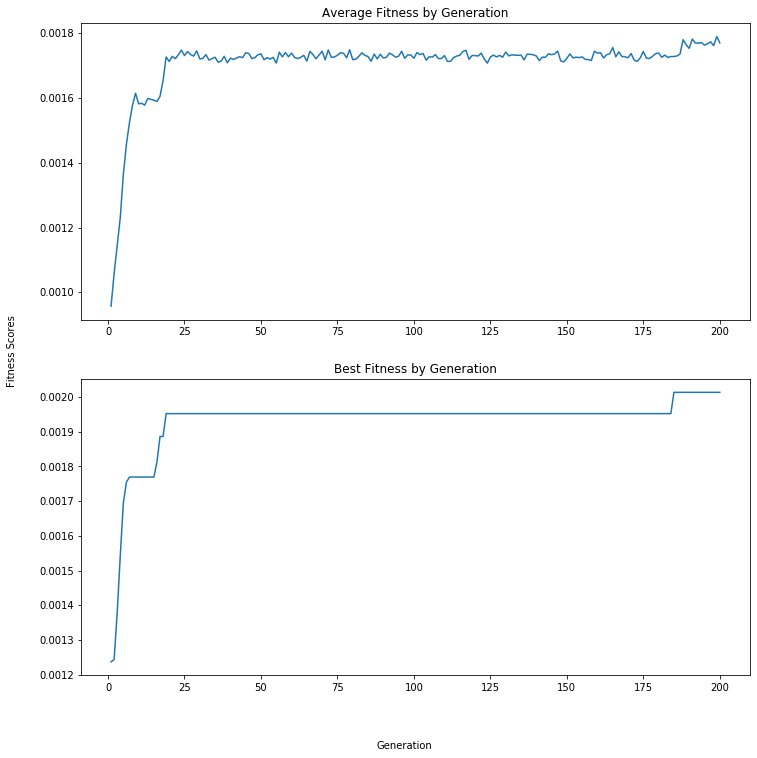

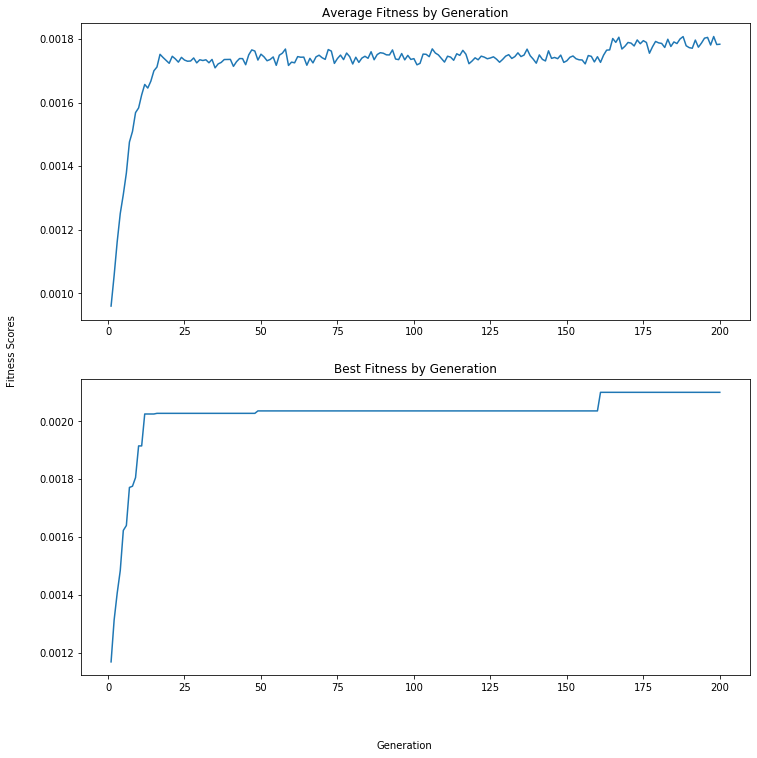

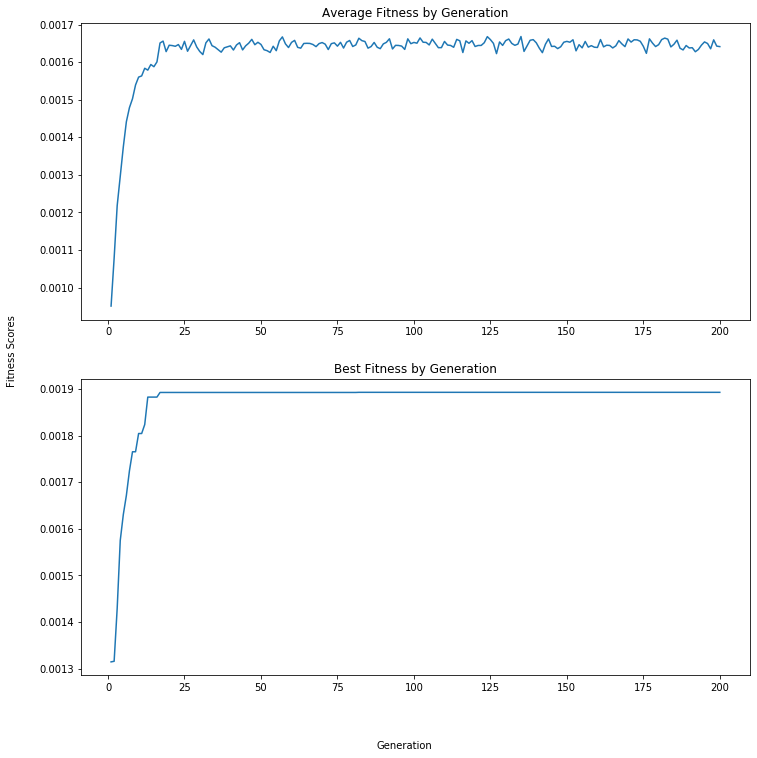

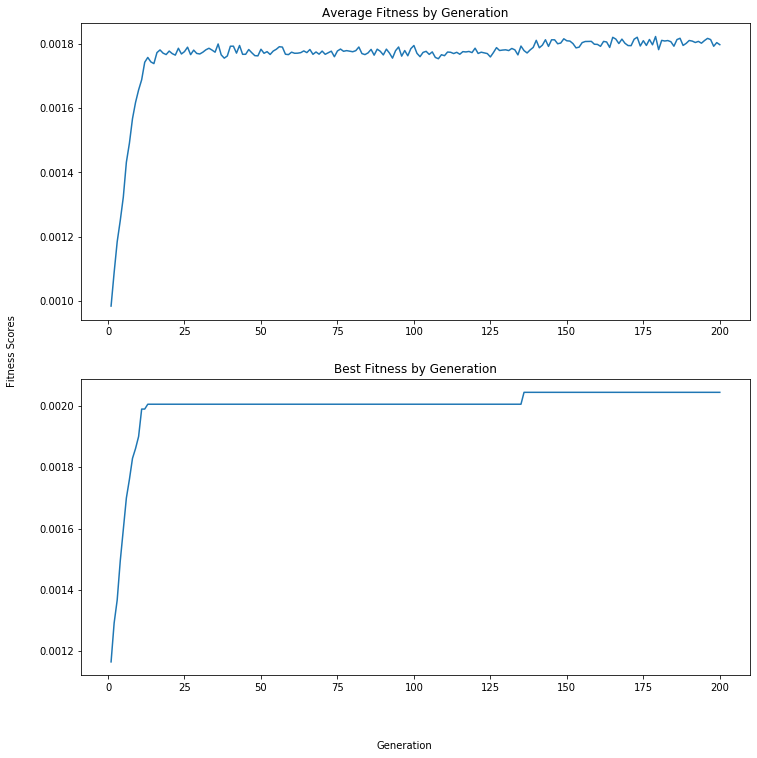

In [149]:
#Read in tsp file
nodes = read_tsp("Random22.tsp")

results = []
dists = []
times = []
best_dist = math.inf
best_path = None
paths = []

#Run ga algorithm 15 times
for i in range(0,15):
    start_time = time.time()
    print()
    print("Generation " + str(i))
    print()
    dist, path = run_ga_tsp(nodes, 200, 0.01, 200, 10, rank_population_elite)
    run_time = time.time()-start_time
    results.append((dist, path, run_time))
    times.append(run_time)
    dists.append(dist)
    paths.append(path)
    if dist < best_dist:
        best_dist = dist
        best_path = path
        
#Print results
print("Best Overall Path: ")
print(best_path)
print("Distance Statistics: ")
print(stats.describe(dists))
print("Time Statistics: ")
print(stats.describe(times))

In [144]:
#Sort results by ascending cost
sorted_results = sorted(results, key = lambda x: x[0])

#Get 10 best paths of 15 candidates
agg_paths = [i[1] for i in sorted_results [:10]]

#Convert paths into an adjacency matrix with proportions of connections used
adj_matrix = count_connections(agg_paths, len(nodes))

#Make a copy of the adjanency list with b_1=b_2=1 input to the inverse incomplete beta function as a cost function
beta1 = cost_transform(adj_matrix, 1, 1)

#Make a copy of the adjanency list with b_1=b_2=1 input to the inverse incomplete beta function as a cost function
beta3 = cost_transform(adj_matrix, 3, 3)



In [145]:
'''
Solves the given adjacency matrix for the best path using a greedy heuristic
Input: 2D Adjacency matrix with cost weights
Output: Best path found
'''
def greedy_tsp_solve(adj_matrix):
    d = adj_matrix
    '''
    Helper function that finds the next node to be inserted into the tour
    Input: current path (list), adajency matrix (numpy array), list of unvisited nodes (list)
    Output: next node to insert,  the closest edge currently in the tour (tuple)
    '''
    def find_next(path, adj_matrix, node_list):
        closest_node = 0
        current_node = 0
        best_dist = math.inf
        for node in path[:-1]:  #checks each node except.  expects the list to have the starting node at the front and end to complete the cycle and ignores the second instance
            for i in node_list: #checks each unvisited node
                if adj_matrix[node][i] < best_dist:
                    closest_node = i
                    current_node = node
                    best_dist = adj_matrix[node][i]
        node_list.remove(closest_node)  #remove node from the unvisited node list
        return (closest_node, current_node)

    best_tour = None
    best_dist = math.inf
    order = []
    #For each starting node, find the best tour
    for i in range(0, len(d)):
        nodes = [i for i in range(0, len(d))]  #creat a list of unvisited nodes
        head = i
        in_order = [head]  #grab the insertion order
        path = [head, head] #initializes the path with the starting node
        nodes.remove(head)  
        while nodes:
            node, match = find_next(path, d, nodes) #get the next node to insert
            in_order.append(node)
            try:
                next_node = path[path.index(match) + 1] #check the neighbors of the closest edge currently in path to determine insertion order
                prev_node = path[path.index(match) - 1]
                if d[node][next_node] <= d[node][prev_node] or path.index(match) == 0:
                    path.insert(path.index(match)+1, node)
                else:
                    path.insert(path.index(match), node)
            except IndexError:  #catches edge case where the node must be inserted at the end of the path
                path.insert(len(path)-1, node)

        #compute tour length
        tour_length = get_path_length(path, d)
        if tour_length < best_dist:
            best_dist = tour_length
            best_tour = path
            order = in_order

    #increment nodes to match names rather than index (that is, set values to start at 1 rather than 0 to match .tsp file input)
    updated_best_tour = [i+1 for i in best_tour]
    updated_order = [i+1 for i in order]
    print("Best Tour: " + str(updated_best_tour))
    print("Best Tour Length: " + str(best_dist))
    print("Insertion Order: " + str(updated_order))

'''
Computes the cost of a given path using the provided cost matrix
Input: Path (list), cost matrix (2D numpy array)
'''
def get_path_length(path, matrix):
    path_cycle = cycle(path)
    next_node = next(path_cycle)
    path_length = 0
    while True:
        this_node, next_node = next_node, next(path_cycle)
        if next_node == path[0]:
            break
        path_length = path_length + matrix[this_node, next_node]
    return path_length

In [146]:
#Solve beta1 cost matrix with a greedy heuristic
start_time = time.time()
greedy_tsp_solve(beta1)
print("Woc Execution Time for Beta1 " + str(time.time()-start_time))

Best Tour: [5, 9, 2, 11, 8, 10, 3, 7, 1, 6, 4, 5]
Best Tour Length: 2.3636363636363633
Insertion Order: [5, 4, 9, 2, 11, 8, 10, 3, 7, 1, 6]
Woc Execution Time for Beta1 0.008015632629394531


In [147]:
#Solve beta3 cost matrix with a greedy heuristic
start_time = time.time()
greedy_tsp_solve(beta3)
print("Woc Execution Time for Beta1 " + str(time.time()-start_time))

Best Tour: [5, 9, 2, 11, 8, 10, 3, 7, 1, 6, 4, 5]
Best Tour Length: 3.4423018343898106
Insertion Order: [5, 4, 9, 2, 11, 8, 10, 3, 7, 1, 6]
Woc Execution Time for Beta1 0.007524251937866211


In [148]:
#Calculate cost of the best path from the genetic algorithm in terms of the beta cost function
idx_best_path = [i-1 for i in best_path]

ga1_cost = get_path_length(idx_best_path, beta1)

ga3_cost = get_path_length(idx_best_path, beta3)

print("Beta1 GA Cost: " + str(ga1_cost))
print("Beta3 GA Cost: " + str(ga3_cost))

Beta1 GA Cost: 2.090909090909091
Beta3 GA Cost: 3.2537311238267543
